In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import random
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder

### Load Dataset

In [3]:
dataset = read_csv('clear_nj.csv')
index   = read_csv('index.csv').values
time    = dataset.values[:64,1:97].astype('float32')
power   = dataset.values[:64,-7:-4].astype('float32')
temp    = dataset.values[:64,-4:].astype('float32')

# normalize features
#归一化;归一化通常有两种：最值归一化和均值方差归一化，这里采用最值归一化
scaler1 = MinMaxScaler(feature_range=(0.1, 0.9)).fit(time) #最大最小值归一化
scaler2 = MinMaxScaler(feature_range=(0.1, 0.9)).fit(power) #最大最小值归一化
scaler3 = MinMaxScaler(feature_range=(0.1, 0.9)).fit(temp) #最大最小值归一化
# scaler1 = StandardScaler().fit(time) #最大最小值归一化
# scaler2 = StandardScaler().fit(power) #最大最小值归一化
# scaler3 = StandardScaler().fit(temp) #最大最小值归一化

scaled_time = scaler1.fit_transform(time) #
scaled_pow  = scaler2.fit_transform(power) #
scaled_temp = scaler3.fit_transform(temp) #

print(time[0,:], '\n', time[-1,:])
print(power[0,:],'\n', power[-1,:])
print(temp[0,:], '\n', temp[-1,:])

[1392.111  1431.4233 1423.0066 1410.7123 1372.748  1386.267  1381.3723
 1378.4746 1353.293  1335.6223 1320.3523 1333.945  1330.4126 1339.6173
 1313.3643 1301.4497 1296.531  1299.255  1305.5079 1317.6346 1315.7377
 1339.5693 1361.6046 1400.4777 1428.1663 1446.1556 1466.024  1468.502
 1481.8534 1496.226  1527.27   1571.114  1624.5447 1671.1204 1719.1327
 1754.1787 1798.2473 1819.5096 1848.9707 1861.4313 1885.8729 1900.818
 1932.3964 1942.5647 1938.48   1895.8207 1834.9507 1790.488  1764.1803
 1769.1963 1778.1836 1788.3136 1805.0197 1809.765  1815.3016 1811.8053
 1816.3494 1821.587  1815.79   1808.665  1808.1364 1822.047  1845.4183
 1864.1094 1880.1893 1881.735  1893.3247 1903.36   1933.1036 1961.5393
 1998.0183 2023.2023 2027.2847 2009.187  1989.5627 1970.744  1982.5453
 1994.414  2010.9124 1976.8947 1940.9207 1897.5177 1898.53   1895.3646
 1893.88   1858.2617 1831.558  1801.2733 1768.919  1718.2664 1669.4626
 1633.112  1615.0703 1596.0057 1562.915  1501.415 ] 
 [1710.195  1691.14   1683

In [4]:
index.shape

(118, 1)

In [5]:
power.shape

(64, 3)

In [6]:
def datamap(time, power, temp, index):
    '''
     data: sequency 
     index: 
    '''
    seq = np.array([])
    for i in range(time.shape[0]):
        seq = np.concatenate((seq, time[i,:]), axis=0)
    
    seq_pow = np.array([])
    for i in range(power.shape[0]):
        seq_pow = np.concatenate((seq_pow, power[i,:]), axis=0)
    
    total_x = []
    total_y = []    
    for m in range(1,5473):
        pow_index = []
        for indx in index:   
            pow_index.append(np.squeeze(seq[-(m+indx)], axis=0))

        total_x.append(np.concatenate((pow_index, seq_pow[-int((m//96)+24): -(int(m//96)+3)], temp[-int(m//96),:]), axis=0))
        total_y.append(seq[-m]) 
        
    return total_x, total_y #total_x(:119)——> 功率时间序列 (119:-4)——>功率最大最小均值 (-4:)温度

In [7]:
total_x, total_y = datamap(scaled_time, scaled_pow, scaled_temp, index)

In [9]:
indx = int(math.floor(0.9*len(total_x)))
# seed = 1234
# random.seed(seed)
# random.shuffle(total_x)
# random.seed(seed)
# random.shuffle(total_y)   随机划分的话会报错


train_x = np.array(total_x[: indx]).astype('float32')
train_y = np.array(total_y[: indx]).astype('float32')
test_x  = np.array(total_x[indx:]).astype('float32')
test_y  = np.array(total_y[indx:]).astype('float32')
print(train_x.shape, test_x.shape)

(4924, 143) (548, 143)


### Build Model

In [10]:
class dual_model(nn.Module): #双流模型
    def __init__(self): #参数初始化
        super(dual_model, self).__init__() #lstm 和三个线性层
        self.d11   = nn.Linear(16, 32) #时序 0-16
        self.d12   = nn.Linear(16, 32) #时序 16-32
        self.d13   = nn.Linear(17, 32) #时序 
        self.d14   = nn.Linear(17, 32) #时序 
        self.d15   = nn.Linear(17, 32) #时序 
        self.d16   = nn.Linear(18, 32) #时序 
        self.d17   = nn.Linear(17, 32) #时序 
        
        self.LSTM1 = nn.LSTM(32, 32, batch_first=True) #时序 通道batch是第一个维度
        self.LSTM2 = nn.LSTM(32, 32, batch_first=True) #时序 通道batch是第一个维度
        self.LSTM3 = nn.LSTM(32, 32, batch_first=True) #时序 通道batch是第一个维度
        self.LSTM4 = nn.LSTM(32, 32, batch_first=True) #时序 通道batch是第一个维度
        self.LSTM5 = nn.LSTM(32, 32, batch_first=True) #时序 通道batch是第一个维度
        self.LSTM6 = nn.LSTM(32, 32, batch_first=True) #时序 通道batch是第一个维度
        self.LSTM7 = nn.LSTM(32, 32, batch_first=True) #时序 通道batch是第一个维度

        self.d2   = nn.Linear(21, 26) #天气
        self.d3   = nn.Linear(4, 6) #最大最小平均功率
        
        self.d4   = nn.Linear(32, 32) #时序非时许融合
        self.d5   = nn.Linear(32, 1) #时序非时许融合
        
        self.relu = nn.LeakyReLU() #Relu 激活函数 模型的输出限制0-1 
        # self.tanh = nn.Tanh() #Relu 激活函数 模型的输出限制0-1 
        self.drop = nn.Dropout(p=0.2)
            
    def forward(self, x1, x2, x3): #前向过程 self.d1 全局变量 两个输入对应时序与非时序
        x11   = self.relu(self.d11(x1[:,:16]))
        x12   = self.relu(self.d12(x1[:,16:32]))
        x13   = self.relu(self.d13(x1[:,32:49]))
        x14   = self.relu(self.d14(x1[:,49:66]))
        x15   = self.relu(self.d15(x1[:,66:83]))
        x16   = self.relu(self.d16(x1[:,83:101]))
        x17   = self.relu(self.d17(x1[:,101:]))
   
        info1, (hn1, cn1) = self.LSTM1(x11) 
        info2, (hn2, cn2) = self.LSTM2(x12) 
        info3, (hn3, cn3) = self.LSTM3(x13) 
        info4, (hn4, cn4) = self.LSTM4(x14) 
        info5, (hn5, cn5) = self.LSTM5(x15) 
        info6, (hn6, cn6) = self.LSTM6(x16) 
        info7, (hn7, cn7) = self.LSTM7(x17) 
        
        info = (info1+info2+info3+info4+info5+info6+info7)/7
        
        x2 = self.relu(self.d2(x2))
        x3 = self.relu(self.d3(x3))
        no_seq = self.relu(self.d4(torch.cat([x2, x3], dim=1)))
        
        fuse = torch.add(info, no_seq) #将温度信息与时序信息融合
        
        return self.relu(self.d5(fuse))#融合之后再经历一次线性层输出后relu函数激活

In [11]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.model = dual_model().cuda() #模型
        self.loss  = nn.L1Loss()  #绝对值损失 mae
        self.batch = 256 #一次喂多少个数据给模型
        self.opt   = torch.optim.Adam(self.model.parameters(), lr=2e-5, weight_decay = 2e-5) #定义一个adam优化器 参数 学习率 
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size = 150, gamma=0.99)
        self.epochs    = 2500 #训练轮数
        self.train_loss= [] #训练损失 为损失函数可视化准备
        self.eval_loss = []#测试损失
        
    def fit(self, train_x, train_y, test_x, test_y, save_path='save/'):
        for epoch in tqdm(range(self.epochs)): #可视化进度条
            batch_loss = [] #一个batch的损失
            # self.model.train() 
            lr = self.opt.param_groups[0]['lr']
            for i in range(0, len(train_x), self.batch):
                x1 = torch.tensor(train_x[i:i+self.batch, :118]).cuda()
                x2 = torch.tensor(train_x[i:i+self.batch, 118:-4]).cuda()
                x3 = torch.tensor(train_x[i:i+self.batch, -4:]).cuda()
                y  = torch.tensor(train_y[i:i+self.batch]).unsqueeze(-1).cuda() #维度扩充
                pred = self.model(x1, x2, x3)
                loss = self.loss(pred, y)
                loss.backward() #计算梯度
                self.opt.step() #优化 
                self.scheduler.step()
                loss = loss.detach().cpu() 
                batch_loss.append(loss)
                  
            if epoch%100==0:      
                # self.model.eval()
                self.save_params(save_path+str(epoch)+'.model')
                print(lr, sum(batch_loss)/len(batch_loss)) #平均batch损失
                eval_x = test_x 
                eval_y = torch.tensor(test_y).unsqueeze(-1).cuda() #将y 从np里的数组转为张量 pytorch框架只能对张量计算
                pred = self.pred(eval_x)
                loss = self.loss(pred.squeeze(0), eval_y).detach().cpu()  
                
                self.train_loss.append(sum(batch_loss)/len(batch_loss))
                self.eval_loss.append(loss)
                # self.model.train() 
                
        
        return self.train_loss, self.eval_loss #每一百轮的损失函数  列表
     

    def pred(self, test_x):  #预测
        # self.model.eval()
        with torch.no_grad():
            x1 = torch.tensor(test_x[:,:118]).cuda()
            x2 = torch.tensor(test_x[:,118:-4]).cuda()
            x3 = torch.tensor(test_x[:,-4:]).cuda()
            pred = self.model(x1, x2, x3)
        return pred
    
    
    def evaluate(self, test_x, test_y): 
        # self.model.eval()
        eval_loss = []
        for i in range(len(test_y)):
            x1 = torch.tensor(test_x[i, :118]).unsqueeze(0).cuda()
            x2 = torch.tensor(test_x[i, 118:-4]).unsqueeze(0).cuda()
            x3 = torch.tensor(test_x[i, -4:]).unsqueeze(0).cuda()  
            y  = torch.tensor(test_y[i]).unsqueeze(-1).cuda()
            pred = self.model(x1, x2, x3).squeeze(0)
            loss = self.loss(pred, y).detach().cpu()  
            eval_loss.append(loss)
            
            # eval_loss.append(loss.item()/y.item())    
            
        print(eval_loss)
        perc = (sum(eval_loss)/len(eval_loss))/(sum(test_y)/len(test_y))*100 
        # perc = (sum(eval_loss)/len(eval_loss))*100 

        print('Percentage error is :', perc)
        
        
    def save_params(self, path):
        torch.save(self.state_dict(), path)
    
    def load_params(self, path):
        self_state = self.state_dict()
        loaded_state = torch.load(path)
        for name, param in loaded_state.items():
            origname = name
            if name not in self_state:
                name = name.replace("module.", "")
                if name not in self_state:
                    print("%s is not in the model."%origname)
                    continue
            if self_state[name].size() != loaded_state[origname].size():
                print("Wrong parameter length: %s, model: %s, loaded: %s"%(origname, self_state[name].size(), loaded_state[origname].size()))
                continue
            self_state[name].copy_(param)           
          
    
# Create an instance of the model
model = MyModel().cuda()

### Fitting

In [11]:
train_loss, eval_loss = model.fit(train_x, train_y, test_x, test_y)

  0%|                                                                                 | 1/2500 [00:00<14:42,  2.83it/s]

2e-05 tensor(0.4632)


  4%|███▏                                                                           | 101/2500 [00:25<09:55,  4.03it/s]

1.7550420459979353e-05 tensor(0.1171)


  8%|██████▎                                                                        | 201/2500 [00:50<09:56,  3.86it/s]

1.5400862916103097e-05 tensor(0.0704)


 12%|█████████▌                                                                     | 301/2500 [01:15<09:09,  4.00it/s]

1.33794351713936e-05 tensor(0.0550)


 16%|████████████▋                                                                  | 401/2500 [01:40<08:57,  3.90it/s]

1.1740735638749682e-05 tensor(0.0418)


 20%|███████████████▊                                                               | 501/2500 [02:05<08:14,  4.05it/s]

1.0302742348476063e-05 tensor(0.0470)


 24%|██████████████████▉                                                            | 601/2500 [02:29<07:59,  3.96it/s]

8.950464275276211e-06 tensor(0.0456)


 28%|██████████████████████▏                                                        | 701/2500 [02:55<07:29,  4.01it/s]

7.854220567156095e-06 tensor(0.0425)


 32%|█████████████████████████▎                                                     | 801/2500 [03:19<06:58,  4.06it/s]

6.89224366695035e-06 tensor(0.0380)


 36%|████████████████████████████▍                                                  | 901/2500 [03:44<06:34,  4.05it/s]

5.987607826246625e-06 tensor(0.0287)


 40%|███████████████████████████████▏                                              | 1001/2500 [04:09<06:16,  3.98it/s]

5.254251745004564e-06 tensor(0.0228)


 44%|██████████████████████████████████▎                                           | 1101/2500 [04:33<05:49,  4.01it/s]

4.610716366370519e-06 tensor(0.0243)


 48%|█████████████████████████████████████▍                                        | 1201/2500 [04:58<05:21,  4.04it/s]

4.005540537149785e-06 tensor(0.0204)


 52%|████████████████████████████████████████▌                                     | 1301/2500 [05:22<04:54,  4.07it/s]

3.5149460298235142e-06 tensor(0.0198)


 56%|███████████████████████████████████████████▋                                  | 1401/2500 [05:47<04:32,  4.03it/s]

3.084439035876891e-06 tensor(0.0184)


 60%|██████████████████████████████████████████████▊                               | 1501/2500 [06:12<04:16,  3.89it/s]

2.6795934971592335e-06 tensor(0.0181)


 64%|█████████████████████████████████████████████████▉                            | 1601/2500 [06:36<03:49,  3.92it/s]

2.3513996268485527e-06 tensor(0.0171)


 68%|█████████████████████████████████████████████████████                         | 1701/2500 [07:01<03:23,  3.92it/s]

2.0634026060315337e-06 tensor(0.0166)


 72%|████████████████████████████████████████████████████████▏                     | 1801/2500 [07:26<02:52,  4.05it/s]

1.7925723740464923e-06 tensor(0.0163)


 76%|███████████████████████████████████████████████████████████▎                  | 1901/2500 [07:51<02:27,  4.06it/s]

1.573019943472966e-06 tensor(0.0159)


 80%|██████████████████████████████████████████████████████████████▍               | 2001/2500 [08:15<02:03,  4.04it/s]

1.380358069994176e-06 tensor(0.0156)


 84%|█████████████████████████████████████████████████████████████████▌            | 2101/2500 [08:40<01:39,  4.02it/s]

1.1991802934293088e-06 tensor(0.0153)


 88%|████████████████████████████████████████████████████████████████████▋         | 2201/2500 [09:05<01:13,  4.07it/s]

1.0523059178502892e-06 tensor(0.0150)


 92%|███████████████████████████████████████████████████████████████████████▊      | 2301/2500 [09:29<00:50,  3.97it/s]

9.234205655398535e-07 tensor(0.0148)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2401/2500 [09:54<00:24,  4.07it/s]

8.022177497375096e-07 tensor(0.0147)


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [10:18<00:00,  4.04it/s]


In [16]:
0.0147/(sum(test_y)/len(test_y))

0.0767553114721815

### Visualization

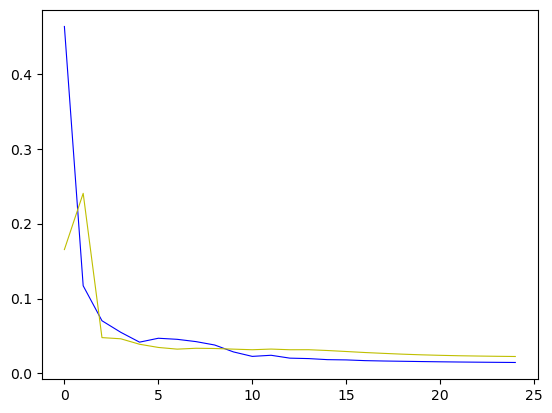

In [12]:
plt.plot(train_loss, color='b', label='train_loss', linewidth=0.8) #训练
plt.plot(eval_loss, color='y', label='eval_loss', linewidth=0.8) #测试
plt.show()

### Evaluation

In [12]:
model.load_params('save/2400.model')

In [13]:
model.evaluate(test_x, test_y)

[tensor(0.0037), tensor(0.0049), tensor(0.0324), tensor(0.0561), tensor(0.0721), tensor(0.0792), tensor(0.0782), tensor(0.0545), tensor(0.0450), tensor(0.0340), tensor(0.0358), tensor(0.0240), tensor(0.0073), tensor(0.0075), tensor(0.0175), tensor(0.0423), tensor(0.0723), tensor(0.0564), tensor(0.0594), tensor(0.0632), tensor(0.0717), tensor(0.0619), tensor(0.0583), tensor(0.0578), tensor(0.0444), tensor(0.0260), tensor(0.0197), tensor(0.0392), tensor(0.0414), tensor(0.0480), tensor(0.0227), tensor(0.0355), tensor(0.0388), tensor(0.0726), tensor(0.0631), tensor(0.0452), tensor(0.0109), tensor(0.0137), tensor(0.0308), tensor(0.0129), tensor(0.0118), tensor(0.0864), tensor(0.0946), tensor(0.1003), tensor(0.0652), tensor(0.0909), tensor(0.1123), tensor(0.0705), tensor(0.0357), tensor(0.0096), tensor(0.0514), tensor(0.0460), tensor(0.0453), tensor(0.0097), tensor(0.0447), tensor(0.0650), tensor(0.0620), tensor(0.0254), tensor(0.0203), tensor(0.0732), tensor(0.0925), tensor(0.0660), tensor(

In [1]:
## SVR

In [2]:
import numpy as np
import pandas as pd
import random
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [3]:
# 导入原始数据
rawData = pd.read_csv('clear_nj.csv')
print("原始数据集大小：",rawData.shape)
rawData.head()

原始数据集大小： (64, 104)


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,93,94,95,96,97,98,99,100,101,102
0,0,1392.110962,1431.423299,1423.006633,1410.712321,1372.748006,1386.267008,1381.372314,1378.474650,1353.293009,...,1596.005697,1562.915039,1501.415039,1687.569635,2027.284668,1296.531006,5.0,4.0,13.0,8.5
1,1,1423.492635,1432.937866,1426.656996,1411.491794,1396.852241,1392.675117,1386.760661,1390.488335,1373.087009,...,1528.079902,1514.115017,1488.726685,1658.425721,2005.593099,1326.901218,6.0,6.0,16.0,11.0
2,2,1430.280640,1420.543199,1413.930217,1400.394572,1400.257121,1391.048218,1384.900770,1390.057454,1375.930677,...,1515.199449,1511.032444,1500.180990,1667.856226,1994.833442,1327.609795,7.0,5.0,14.0,9.5
3,3,1422.384969,1419.095649,1420.381443,1403.464111,1406.665989,1385.270983,1384.153998,1378.939575,1367.141574,...,1523.640557,1508.972887,1482.254313,1693.898704,2030.042006,1327.427897,1.0,2.0,16.0,9.0
4,4,1423.677328,1427.221544,1432.587104,1424.418769,1420.740994,1401.911092,1398.999213,1396.804335,1392.359239,...,1551.838338,1529.568888,1500.319336,1721.773081,2054.819783,1347.431912,2.0,6.0,21.0,13.5


In [5]:
# 对所有数值类型的特征进行标准化处理
# 每一个因素的均值和方差都存储到 scaled_features 变量中。
quant_features = [ '0', '1', '2', '3']
scaled_features = {}
for each in quant_features:
    mean, std = rawData[each].mean(), rawData[each].std()
    scaled_features[each] = [mean, std]
    rawData.loc[:, each] = (rawData[each] - mean)/std
rawData.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,93,94,95,96,97,98,99,100,101,102
0,0,-1.878602,-1.408746,-1.383479,-1.316110,1372.748006,1386.267008,1381.372314,1378.474650,1353.293009,...,1596.005697,1562.915039,1501.415039,1687.569635,2027.284668,1296.531006,5.0,4.0,13.0,8.5
1,1,-1.513178,-1.389328,-1.334263,-1.305256,1396.852241,1392.675117,1386.760661,1390.488335,1373.087009,...,1528.079902,1514.115017,1488.726685,1658.425721,2005.593099,1326.901218,6.0,6.0,16.0,11.0
2,2,-1.434135,-1.548239,-1.505851,-1.459778,1400.257121,1391.048218,1384.900770,1390.057454,1375.930677,...,1515.199449,1511.032444,1500.180990,1667.856226,1994.833442,1327.609795,7.0,5.0,14.0,9.5
3,3,-1.526076,-1.566798,-1.418873,-1.417037,1406.665989,1385.270983,1384.153998,1378.939575,1367.141574,...,1523.640557,1508.972887,1482.254313,1693.898704,2030.042006,1327.427897,1.0,2.0,16.0,9.0
4,4,-1.511027,-1.462617,-1.254311,-1.125255,1420.740994,1401.911092,1398.999213,1396.804335,1392.359239,...,1551.838338,1529.568888,1500.319336,1721.773081,2054.819783,1347.431912,2.0,6.0,21.0,13.5


In [12]:
rawDataNP = rawData.values[1:4,:]
rawDataNP.shape

(3, 104)

In [ ]:
# 线性核函数配置支持向量机
linear_svr = SVR(kernel="linear")
# 训练
linear_svr.fit(x_train, y_train)
# 预测 保存预测结果
linear_svr_y_predict = linear_svr.predict(x_test)

plt.plot(y_test)
plt.plot(linear_svr_y_predict)
plt.show()